In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv2

C:\Users\PeterBaksh\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\PeterBaksh\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\PeterBaksh\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [4]:
path = r'C:\Users\PeterBaksh\Downloads\china_growth.png'

In [170]:
# Create a list to store the clicked points

############### Calibrate the axis ###############
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        clicked_points.append((x, y))
        print("Clicked at pixel coordinates (", x, ",", y, ")")
        
def calibrate_axis(image, clicked_points):
    print('Select values for x min x max y min and y max, q to exit')
    
    cv2.namedWindow('Image')
    cv2.setMouseCallback('Image', mouse_callback)
    cv2.imshow('Image', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    coordinates =  clicked_points
    xmin = coordinates[0][0]
    xmax = coordinates[1][0]
    ymax = coordinates[2][1]
    ymin = coordinates[3][1]
    return xmin, xmax, ymin, ymax

def extract_real_axis_values(image):
    print ('Input Real Axis Values')
    cv2.imshow('Image', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    print('Xmin')
    true_xmin = input()

    cv2.imshow('Image', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    print('Xmax')
    true_xmax = input()

    cv2.imshow('Image', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    print('ymin')
    true_ymin = input()

    cv2.imshow('Image', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    print('ymax')
    true_ymax = input()
    
    return true_xmin, true_xmax, true_ymin, true_ymax

def select_line_colour(image, clicked_points):
    print('Select the line to identify the colour we wish to extract-  then q')
    image = cv2.imread(path)
    cv2.namedWindow('Image')
    cv2.setMouseCallback('Image', mouse_callback)

    # Display the image in the window
    cv2.imshow('Image', image)

    # Wait for a key press and then close the window
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    print(clicked_points)

    # Extract the RGB values of the clicked points

    b, g, r = cv2.split(image)

    for point in clicked_points:
        print("RGB values at point", point, ":", r[point[1], point[0]], g[point[1], point[0]], b[point[1], point[0]])
        print("Adjusted BGR values at point", point, ":", b[point[1], point[0]], g[point[1], point[0]], r[point[1], point[0]])
    return np.array([b[point[1], point[0]], g[point[1], point[0]], r[point[1], point[0]]])


def convert_x(xmin, xmax, true_xmin, true_xmax ,value):
    diff = xmax - xmin
    true_diff = true_xmax - true_xmin
    gradient = true_diff / diff
    c  =  true_xmin - (gradient * xmin)
    return c + value * gradient
    
def convert_y(ymin, ymax, true_ymin, true_ymax ,value):
    diff = ymax - ymin
    true_diff = true_ymax - true_ymin
    gradient = true_diff / diff
    c  =  true_ymin - (gradient * ymin)
    return c + value * gradient

def extract_target_line_colour(image, rgb):
    print('select line by colour')
    target_color = rgb # For example, target pure red color

    # Define the tolerance level as a percentage
    tolerance = 10

    # Calculate the upper and lower bounds for each RGB channel based on the target color and tolerance
    lower_bound = target_color - (target_color * tolerance / 100)
    upper_bound = target_color + (target_color * tolerance / 100)

    # Create a boolean mask that selects the pixels within the specified range
    mask = np.all((image >= lower_bound) & (image <= upper_bound), axis=2)

    # Set all pixels that don't match the desired range to 0
    image[~mask] = [0, 0, 0]

    # Display the resulting image
    cv2.imshow('Result', image)

    # Wait for a key press and then close the window
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return image 

def remove_legend_bits(line_only):
    print('select any regions to set to 0')
    # Allow the user to select a region of interest using the mouse
    roi = cv2.selectROI('Image', image, fromCenter=False, showCrosshair=True)

    # Crop the image to the selected ROI
    x, y, w, h = roi
    cropped_image = image[y:y+h, x:x+w]
    import copy
    new_image = copy.deepcopy(image)
    new_image[y:y+h, x:x+w] =0

    # Display the cropped image in a window
    cv2.imshow('Cropped Image', new_image)

    # Wait for a key press and then close the windows
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return new_image

def get_data(new_image):
    points = np.argwhere(new_image > 1)
    x = points [:, 1]
    y = points[:, 0]
    x_real = [convert_x(xmin, xmax, true_xmin, true_xmax ,i) for i in x]
    y_real = [convert_x(ymin, ymax, true_ymin, true_ymax ,i) for i in y]
    df = pd.DataFrame({'x':x_real, 'y':y_real})
    df = df.sort_values(by ='x')
    df.plot(x = 'x', y = 'y')
    return df

Select the line to identify the colour we wish to extract-  then q
Clicked at pixel coordinates ( 293 , 457 )
[(293, 457)]
RGB values at point (293, 457) : 15 84 153
Adjusted BGR values at point (293, 457) : 153 84 15
select line by colour
select any regions to set to 0


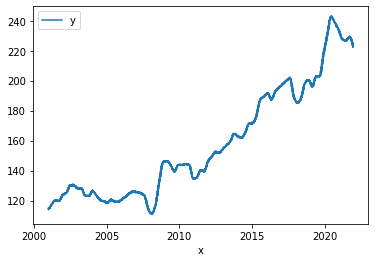

In [177]:
path = r'C:\Users\PeterBaksh\Downloads\china_growth.png'
output_name = 'emerging_market_economies.csv'
image = image = cv2.imread(path)
clicked_points = []
# xmin, xmax, ymin, ymax = calibrate_axis(image, clikced_points)

xmin = 65
xmax = 702
ymin = 412
ymax = 107


# true_xmin, true_xmax, true_ymin, true_ymax = extract_real_axis_values(image)

true_xmin = 2001
true_xmax = 2022
true_ymin = 150
true_ymax = 300

clicked_points = []
rgb = select_line_colour(image, clicked_points)
# 
# rgb = np.array([230, 220, 112])

line_only = extract_target_line_colour(image, rgb)
new_image = remove_legend_bits(line_only)
df = get_data(new_image)

df.to_csv(output_name)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\PeterBaksh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\PeterBaksh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\PeterBaksh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid posit

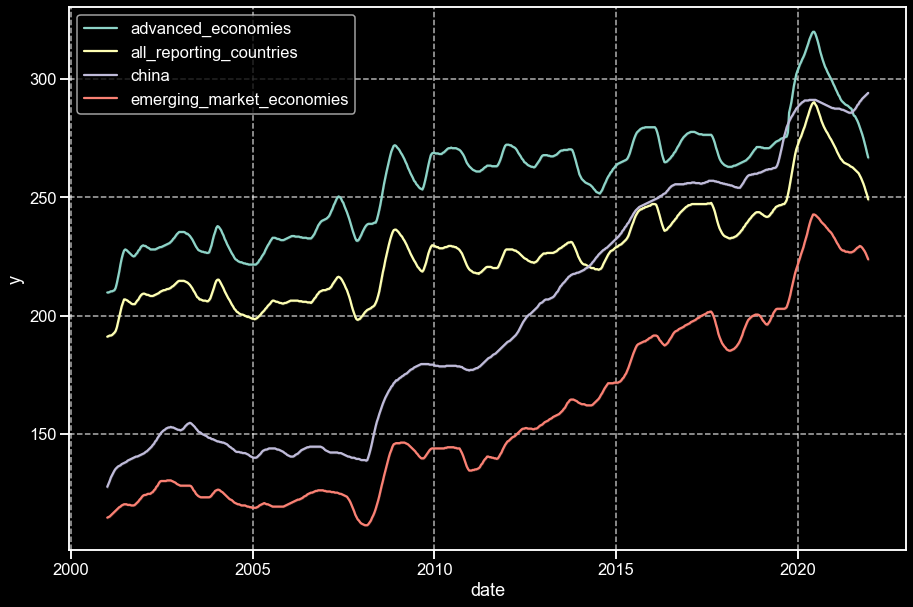

In [197]:
import seaborn as sns
import os
# sns.set_style('whitegrid')
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
fig, ax = plt.subplots()
files = os.listdir()
for file in files:
    if file.endswith('.csv'):
        
        df = pd.read_csv(file)
        x = df.iloc[:, 1]
        y = df.iloc[:, 2]

        # Plot the data on the same axis
        sns.lineplot(x, y, label = file[0:-4], ax = ax, palette="pastel")

    # Add a legend and axis labels
    ax.legend()
    ax.set_xlabel('date')
    
    ax.grid(which='major', linestyle='--', alpha=0.7)
ax.grid(which='major', linestyle='--', alpha=0.7)
# ax.set_facecolor('#ffe6f2')
# ax.spines['bottom'].set_color('#d9d9d9')
# ax.spines['top'].set_color('#d9d9d9')
# ax.spines['left'].set_color('#d9d9d9')
# ax.spines['right'].set_color('#d9d9d9')

# Set the background color of the figure to a darker grey
# fig.patch.set_facecolor('#f2f2f2')
fig = plt.gcf()
fig.set_size_inches(15, 10)

In [200]:
fig.savefig('line_graphs.png')